In [119]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from utils import load_galaxy_data
import matplotlib.pyplot as plt


In [120]:
## Use the custom function to load the data
from utils import load_galaxy_data
input_data, labels = load_galaxy_data()

Successfully loaded galaxy data!


In [121]:
## Check the shape of data
print("Input Data Shape: ", input_data.shape)
print("Labels Shape: ", labels.shape)

### There are 1400 images which are 128x128 and RGB [0, 255]
### There are 4 classes, in the form [0,1,0,0], etc.

Input Data Shape:  (1400, 128, 128, 3)
Labels Shape:  (1400, 4)


In [122]:
## Divide the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    input_data, 
    labels, 
    test_size=0.20, 
    random_state=222, 
    shuffle=True, 
    stratify=labels ## This ensures that ratios of galaxies in your testing data will be the same as in the original dataset.
    )

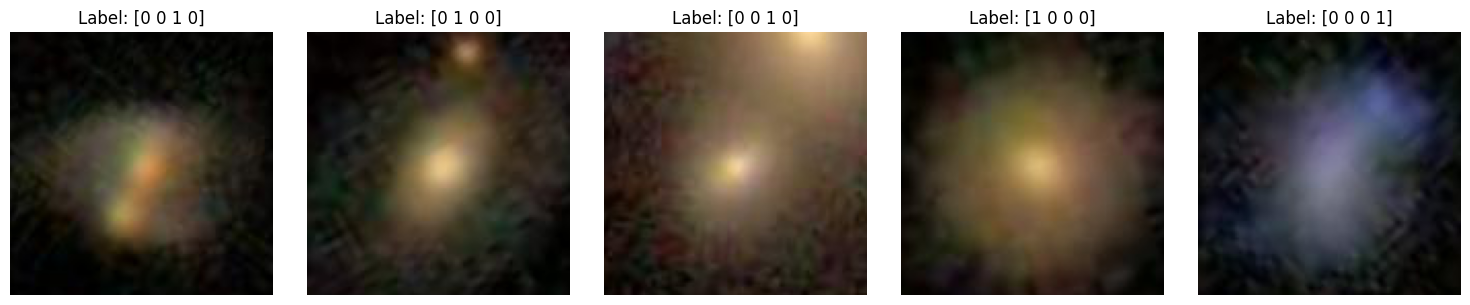

In [123]:
def show_sample_images(X, y, class_names=None, num=5):
    plt.figure(figsize=(15, 3))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(X[i].astype('uint8'))  # assume raw [0,255] scale
        label = y[i]
        label_str = np.argmax(label)
        if class_names:
            label_str = class_names[label_str]
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(X_train, y_train)

In [124]:
## Normalise pixel values to [0, 1]
# X_train = X_train / 255.0
# X_test = X_test / 255.0

# print(f"X_train min: {X_train.min()}, max: {X_train.max()}")
# print(f"X_test min: {X_test.min()}, max: {X_test.max()}")

## OR add a layer that can do it inside the model
Rescaling_Pipeline = tf.keras.layers.Rescaling(scale=1./255)

In [125]:
### Create tf.data Dataset in order to apply transformations (like batching or augmentation) to this dataset.
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [126]:
## Shuffle the training data to prevent learning patterns based on input order.
train_ds = train_ds.shuffle(buffer_size=train_ds.cardinality()) ## shuffle all the data

In [127]:
## data augmentation
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomRotation, RandomZoom

Augmentation_Pipeline = Sequential([
    RandomRotation(0.1),                                # ±10% of a full circle (~±18 degrees)
    RandomZoom(height_factor=0.1, width_factor=0.1),    # Zoom in/out up to 10%
])

def rescale_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = Augmentation_Pipeline(image)
    image = Rescaling_Pipeline(image)
    return image, label

### Note: .map() applies transformations at the time the dataset is iterated, which typically happens during training or validation.
train_ds = train_ds.map(rescale_augment, num_parallel_calls=tf.data.AUTOTUNE)

In [128]:
## resclae test data only:
def rescale_only(image, label):
    image = Rescaling_Pipeline(image)
    return image, label

test_ds = test_ds.map(rescale_only, num_parallel_calls=tf.data.AUTOTUNE)

In [129]:
## Batch the data for efficiency
batch_size = 5
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [130]:
## Performance optimisation
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [131]:
## Build the model
from tensorflow.keras import layers, models

def create_model(input_shape=(128, 128, 3), num_classes=4):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(filters = 16, kernel_size = (3, 3), strides=(1, 1), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),

        # Block 2
        layers.Conv2D(16, (3, 3), strides=(1, 1), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),

        # Block 3
        layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPool2D(pool_size=(2, 2)),

        # Flatten & Dense Layers
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_model()
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 532,532 (2.03 MB)

 Trainable params: 532,276 (2.03 MB)

 Non-trainable params: 256 (1.00 KB)

In [132]:
### Create Optimizer
from tensorflow.keras.optimizers import Adam
my_optimizer = Adam(learning_rate=0.001)

### Define Loss
from tensorflow.keras.losses import CategoricalCrossentropy
my_loss = CategoricalCrossentropy()

### Compile
from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(
    optimizer = my_optimizer,
    loss = my_loss,
    metrics = [
        'categorical_accuracy',
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

In [133]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    verbose=1,
    callbacks=[early_stop, checkpoint, reduce_lr]
)


Epoch 1/50
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - auc: 0.6560 - categorical_accuracy: 0.4075 - loss: 1.4782 - precision: 0.4796 - recall: 0.2963
Epoch 1: val_loss improved from inf to 1.54119, saving model to best_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - auc: 0.6563 - categorical_accuracy: 0.4078 - loss: 1.4770 - precision: 0.4800 - recall: 0.2964 - val_auc: 0.5469 - val_categorical_accuracy: 0.2536 - val_loss: 1.5412 - val_precision: 0.2981 - val_recall: 0.2214 - learning_rate: 0.0010
Epoch 2/50
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - auc: 0.7244 - categorical_accuracy: 0.4814 - loss: 1.2443 - precision: 0.5794 - recall: 0.3300
Epoch 2: val_loss improved from 1.54119 to 1.38644, saving model to best_model.keras
224/224 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - auc: 0.7244 - categorical_accuracy: 0.4814 - loss: 1.2442 - precision: 0.5792 - recall: 0.3299 - val_auc: 0.6678 - val_categorical_accuracy: 0.4250 - val_loss: 1.3864 - val_precision: 0.4725 - val_recall: 0.30

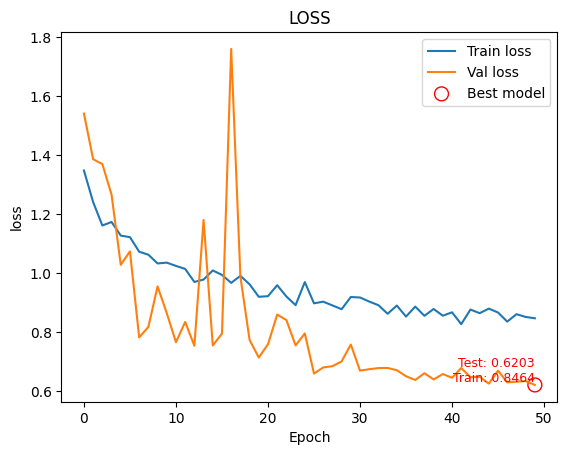

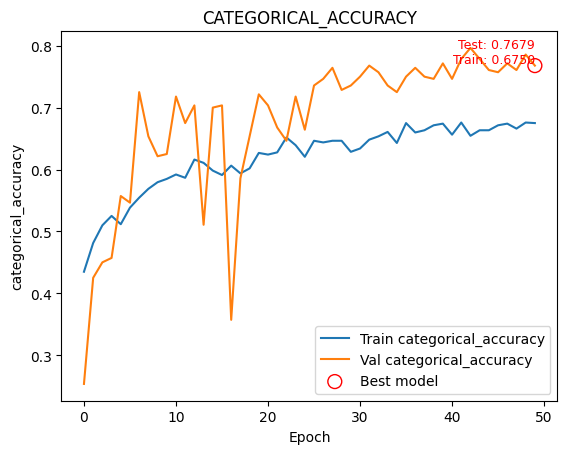

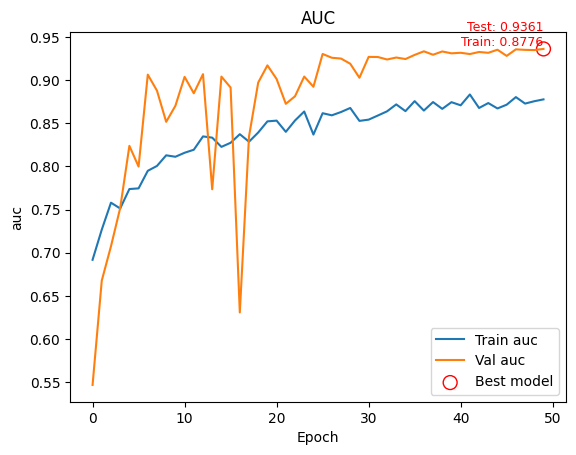

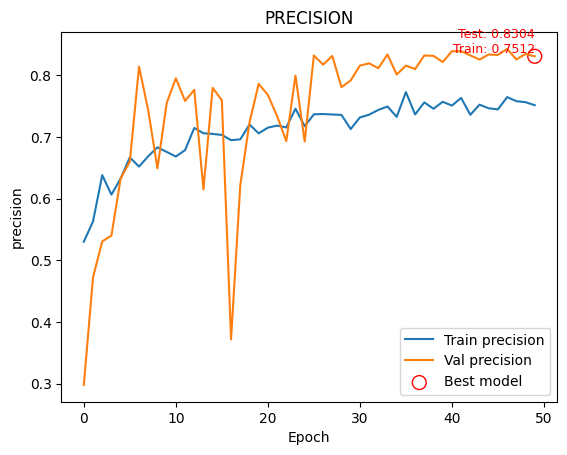

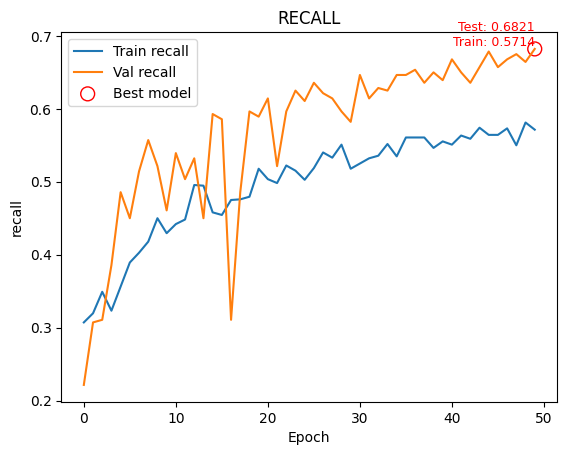

In [134]:
## plot the training
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history):
    metrics = ['loss', 'categorical_accuracy', 'auc', 'precision', 'recall']
    
    # Find epoch with lowest val_loss (best model)
    best_epoch = np.argmin(history.history['val_loss'])
    
    for metric in metrics:
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        
        best_val_metric = history.history[f'val_{metric}'][best_epoch]
        best_train_metric = history.history[metric][best_epoch]
        
        # Circle the best validation metric point
        plt.scatter(best_epoch, best_val_metric, s=100, facecolors='none', edgecolors='r', label='Best model')
        
        # Print the values as text near the circle (adjust position a bit)
        plt.text(best_epoch, best_val_metric, 
                 f"Test: {best_val_metric:.4f}\nTrain: {best_train_metric:.4f}", 
                 fontsize=9, color='red', verticalalignment='bottom', horizontalalignment='right')
        
        plt.title(metric.upper())
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.show()

plot_history(history)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


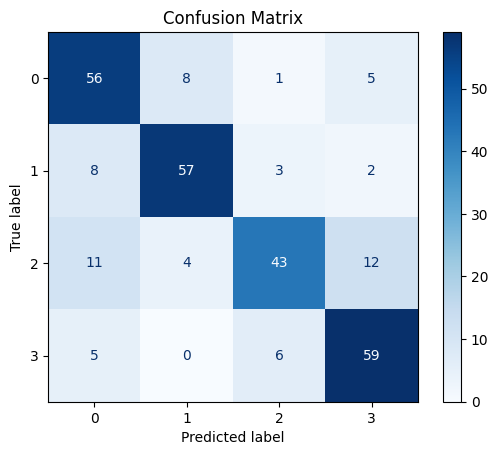

In [135]:
## add confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in test_ds], axis=0)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load the model if necessary
model = load_model("best_model.keras")

# Check the model summary (optional)
model.summary()

```visualize_activations``` takes your Keras model and the validation iterator and does the following:

- It loads in a sample batch of data using your validation iterator.
 
- It uses model.predict() to generate predictions for the first sample images.
 
- Next, it compares those predictions with the true labels and prints the result.
 
- It then saves the image and the feature maps for each convolutional layer using matplotlib.

In [144]:
import visualise
import importlib
importlib.reload(visualise)
visualise.visualize_activations(model,test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Galaxy_0
	Model prediction: [0.87365687 0.03565563 0.04686307 0.0438244 ]
	True label: Regular (0)
	Correct: True
Galaxy_1
	Model prediction: [0.41615412 0.06191789 0.07391876 0.44800922]
	True label: Other (3)
	Correct: True
Galaxy_2
	Model prediction: [0.4199199  0.2965615  0.16538161 0.11813699]
	True label: Regular (0)
	Correct: True
Galaxy_3
	Model prediction: [0.00191589 0.98227686 0.00356689 0.01224028]
	True label: Ringed (1)
	Correct: True
Galaxy_4
	Model prediction: [0.00932314 0.0053563  0.9566517  0.02866889]
	True label: Merger (2)
	Correct: True


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>